**0. Libraries and first configs**

In [189]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from geopy.distance import geodesic


# Read the dataset into a pandas DataFrame
cal = pd.read_csv('calendar.csv')
listings = pd.read_csv('listings.csv')
revs = pd.read_csv('reviews.csv')

**0.1 general exploration of the data:**

In [190]:
listings.describe()

,id,scrape_id,host_id,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,...,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,calculated_host_listings_count,reviews_per_month
count,3.818000e+03,3.818000e+03,3.818000e+03,3816.000000,3816.000000,3818.000000,3818.000000,3818.000000,3802.000000,3812.000000,...,3171.000000,3160.000000,3165.000000,3160.000000,3167.000000,3163.000000,3162.000000,0.0,3818.000000,3191.000000
mean,5.550111e+06,2.016010e+13,1.578556e+07,7.157757,7.157757,47.628961,-122.333103,3.349398,1.259469,1.307712,...,94.539262,9.636392,9.556398,9.786709,9.809599,9.608916,9.452245,NaN,2.946307,2.078919
std,2.962660e+06,0.000000e+00,1.458382e+07,28.628149,28.628149,0.043052,0.031745,1.977599,0.590369,0.883395,...,6.606083,0.698031,0.797274,0.595499,0.568211,0.629053,0.750259,NaN,5.893029,1.822348
min,3.335000e+03,2.016010e+13,4.193000e+03,1.000000,1.000000,47.505088,-122.417219,1.000000,0.000000,0.000000,...,20.000000,2.000000,3.000000,2.000000,2.000000,4.000000,2.000000,NaN,1.000000,0.020000
25%,3.258256e+06,2.016010e+13,3.275204e+06,1.000000,1.000000,47.609418,-122.354320,2.000000,1.000000,1.000000,...,93.000000,9.000000,9.000000,10.000000,10.000000,9.000000,9.000000,NaN,1.000000,0.695000
50%,6.118244e+06,2.016010e+13,1.055814e+07,1.000000,1.000000,47.623601,-122.328874,3.000000,1.000000,1.000000,...,96.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,1.000000,1.540000
75%,8.035127e+06,2.016010e+13,2.590309e+07,3.000000,3.000000,47.662694,-122.310800,4.000000,1.000000,2.000000,...,99.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,2.000000,3.000000
max,1.034016e+07,2.016010e+13,5.320861e+07,502.000000,502.000000,47.733358,-122.240607,16.000000,8.000000,7.000000,...,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,37.000000,12.150000


In [191]:
print(revs.head())

   listing_id        id        date  reviewer_id reviewer_name  \
0     7202016  38917982  2015-07-19     28943674        Bianca   
1     7202016  39087409  2015-07-20     32440555         Frank   
2     7202016  39820030  2015-07-26     37722850           Ian   
3     7202016  40813543  2015-08-02     33671805        George   
4     7202016  41986501  2015-08-10     34959538          Ming   

                                            comments  
0  Cute and cozy place. Perfect location to every...  
1  Kelly has a great room in a very central locat...  
2  Very spacious apartment, and in a great neighb...  
3  Close to Seattle Center and all it has to offe...  
4  Kelly was a great host and very accommodating ...  


In [192]:
print(cal.head())

   listing_id        date available   price
0      241032  2016-01-04         t  $85.00
1      241032  2016-01-05         t  $85.00
2      241032  2016-01-06         f     NaN
3      241032  2016-01-07         f     NaN
4      241032  2016-01-08         f     NaN


**0.2 Cleaning the data**

In [193]:
# 'price' is a column in listings DataFrame and it's in string format with '$'
listings['price'] = listings['price'].replace('[\$,]', '', regex=True).astype(float)

# Select numeric columns only for simplicity
numeric_cols = listings.select_dtypes(include=[np.number])
# Drop rows with missing values
numeric_cols = numeric_cols.dropna(axis=1, how='any')
print(numeric_cols.head())

        id       scrape_id   host_id   latitude   longitude  accommodates  \
0   241032  20160104002432    956883  47.636289 -122.371025             4   
1   953595  20160104002432   5177328  47.639123 -122.365666             4   
2  3308979  20160104002432  16708587  47.629724 -122.369483            11   
3  7421966  20160104002432   9851441  47.638473 -122.369279             3   
4   278830  20160104002432   1452570  47.632918 -122.372471             6   

   price  guests_included  minimum_nights  maximum_nights  availability_30  \
0   85.0                2               1             365               14   
1  150.0                1               2              90               13   
2  975.0               10               4              30                1   
3  100.0                1               1            1125                0   
4  450.0                6               1            1125               30   

   availability_60  availability_90  availability_365  number_of_rev

**1. Discovering factors for high prices**

In [194]:
# Separate features and target
X = numeric_cols.drop('price', axis=1)
y = numeric_cols['price']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Print the coefficients of the model
print(pd.DataFrame(model.coef_, X.columns, columns=['Coefficients']))

Mean Squared Error: 4435.796818351806
                                Coefficients
id                                 -4.825328
scrape_id                           0.000000
host_id                             0.962038
latitude                           -2.479869
longitude                          -4.241546
accommodates                       54.567237
guests_included                     5.129172
minimum_nights                      0.411221
maximum_nights                     -0.887523
availability_30                     3.063212
availability_60                    -2.175409
availability_90                    -4.353747
availability_365                    2.649012
number_of_reviews                  -9.882019
calculated_host_listings_count     -3.091062


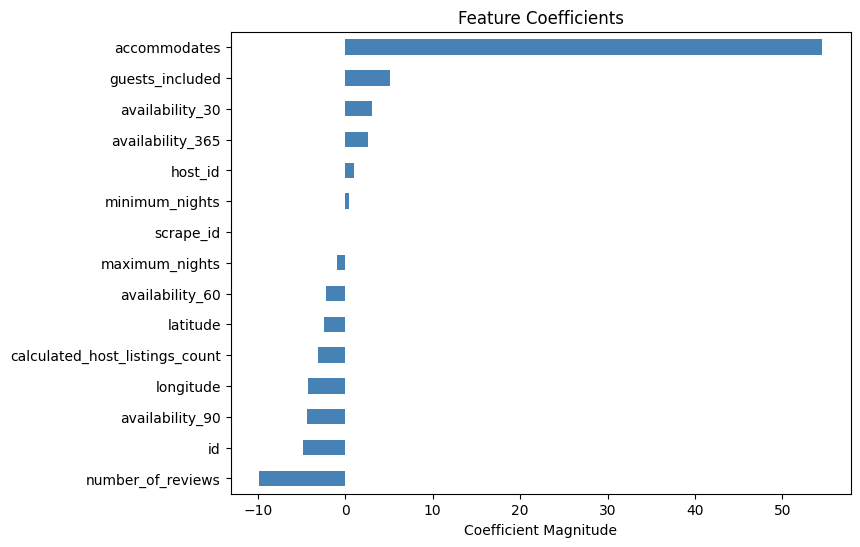

In [195]:
# Get the coefficients
coefficients = pd.DataFrame(model.coef_, X.columns, columns=['Coefficients'])

# Sort the coefficients
coefficients = coefficients.sort_values(by='Coefficients')

# Plot the coefficients
plt.figure(figsize=(8, 6))
coefficients['Coefficients'].plot(kind='barh', color='steelblue')
plt.title('Feature Coefficients')
plt.xlabel('Coefficient Magnitude')
plt.show()

**2.Which property type dominates each price range**

In [196]:
# Merge calendar and listings dataframes
merged_df = pd.merge(cal, listings[['id', 'property_type', 'price']], left_on='listing_id', right_on='id', how='left')

# Filter only booked properties
booked_properties = merged_df[merged_df['available'] == 'f']

/var/folders/wb/rp1h_0ns15q6354trhhypw000000gn/T/ipykernel_80973/3290723791.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  booked_properties['price_bin'] = pd.cut(booked_properties['price_y'], bins=bins, labels=labels)
/var/folders/wb/rp1h_0ns15q6354trhhypw000000gn/T/ipykernel_80973/3290723791.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_price_bin = booked_properties.groupby(['price_bin', 'property_type']).size().reset_index(name='counts')


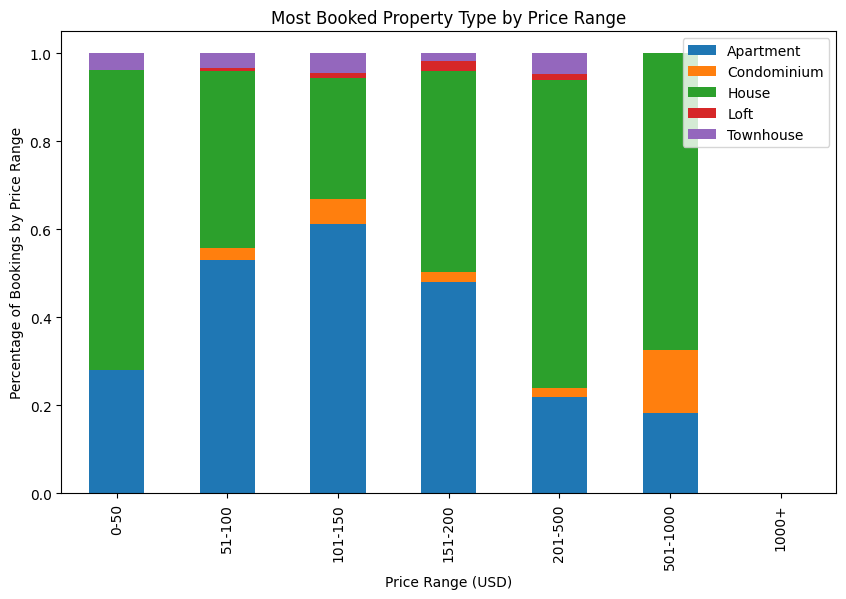

In [197]:
# Define price bins and labels
bins = [0, 50, 100, 150, 200, 500, 1000, np.inf]
labels = ['0-50', '51-100', '101-150', '151-200', '201-500', '501-1000', '1000+']

# Add a new column for price bins
booked_properties['price_bin'] = pd.cut(booked_properties['price_y'], bins=bins, labels=labels)

# Group by price bin and property type
grouped_price_bin = booked_properties.groupby(['price_bin', 'property_type']).size().reset_index(name='counts')

# Filter the grouped dataframe to include only the top 5 property types
grouped_price_bin_top_5 = grouped_price_bin[grouped_price_bin['property_type'].isin(top_property_types)]

# Pivot the dataframe and fill NaNs with 0
pivot_price_bin = grouped_price_bin_top_5.pivot(index='price_bin', columns='property_type', values='counts').fillna(0)

# Normalize the dataframe by row to get percentages
pivot_price_bin = pivot_price_bin.div(pivot_price_bin.sum(axis=1), axis=0)

# Plot by price bin
pivot_price_bin.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.xlabel('Price Range (USD)')
plt.ylabel('Percentage of Bookings by Price Range')
plt.title('Most Booked Property Type by Price Range')
plt.legend()
plt.show()

**3. Does a bad host's response time lead to a bad review?**

In [198]:
# Map host_response_time to numerical values
response_time_mapping = {'within an hour': 1, 'within a few hours': 2, 'within a day': 3, 'a few days or more': 4}
listings['host_response_time_num'] = listings['host_response_time'].map(response_time_mapping)

# Calculate correlation
correlation = listings['host_response_time_num'].corr(listings['review_scores_rating'])

print(correlation)

-0.09858775232139524


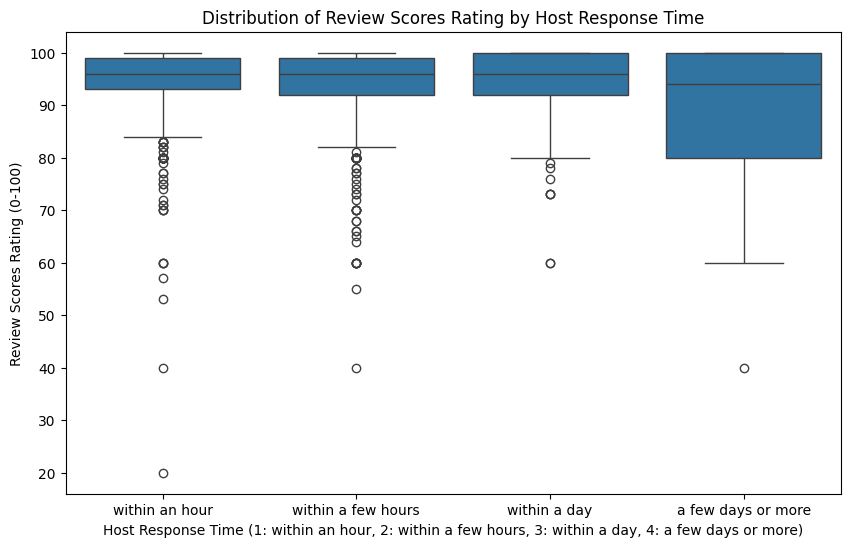

In [199]:
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.boxplot(x='host_response_time', y='review_scores_rating', data=listings, order=response_time_mapping.keys())

plt.xlabel('Host Response Time (1: within an hour, 2: within a few hours, 3: within a day, 4: a few days or more)')
plt.ylabel('Review Scores Rating (0-100)')
plt.title('Distribution of Review Scores Rating by Host Response Time')

plt.show()

**4. Do the top Seattle's attractions make the prices higher?**

In [200]:
# Define the coordinates of the attractions
attractions = {
    'Space Needle': (47.6205, -122.3493),
    'Pike Place Market': (47.6098, -122.3423),
    'Seattle Great Wheel': (47.6062, -122.3426),
    'Chihuly Garden and Glass': (47.6205, -122.3509),
    'Seattle Aquarium': (47.6098, -122.3422)
}

for attraction, coords in attractions.items():
    # Calculate the distance from each listing to the attraction
    listings[attraction + '_distance'] = listings.apply(lambda row: geodesic((row['latitude'], row['longitude']), coords).miles, axis=1)

# Calculate the correlation between the distances and the price
correlations = {attraction: listings['price'].corr(listings[attraction + '_distance']) for attraction in attractions}

print(correlations)

{'Space Needle': -0.18465993921535598, 'Pike Place Market': -0.16357659630415242, 'Seattle Great Wheel': -0.1572746186105928, 'Chihuly Garden and Glass': -0.18648259964509595, 'Seattle Aquarium': -0.16343096352094238}


In [201]:
import folium

# Create a map centered around Seattle
map_seattle = folium.Map(location=[47.6097, -122.3331], zoom_start=13)

# Add markers for the attractions
for attraction, coords in attractions.items():
    folium.Marker(location=coords, popup=attraction, icon=folium.Icon(color='red')).add_to(map_seattle)

# Add markers for the listings
# For performance reasons, let's only add a subset of the listings
for idx, row in listings.sample(n=100).iterrows():
    folium.Marker(location=[row['latitude'], row['longitude']], popup=row['name'], icon=folium.Icon(color='blue')).add_to(map_seattle)

# Display the map
map_seattle